In [19]:
import sys, os
import argparse
import time
from types import SimpleNamespace


import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import faiss
import skimage.io as io

from dataset import CocoDataset, EmbedDataset
from utils import weight_init, collater, sec2str
from model import ImageEncoder, CaptionEncoder
from vocab import Vocabulary
from eval import retrieve_i2c, retrieve_c2i

In [20]:
path = "models/vsepp"
sorted(os.listdir(path))

['epoch_0001_score_005.ckpt',
 'epoch_0002_score_006.ckpt',
 'epoch_0004_score_014.ckpt',
 'epoch_0005_score_023.ckpt',
 'epoch_0006_score_037.ckpt']

In [21]:
def get_args():
    a = {
        "dataset": "coco",
        "checkpoint": os.path.join(path, "epoch_0022_score_222.ckpt"),   # checkpoint from where to load model
        'root_path': '/groups1/gaa50131/datasets/MSCOCO',
        'vocab_path': 'captions_train2017.txt',
        'cnn_type': "resnet152",
        'rnn_type': "GRU",
        'emb_size': 300,
        'out_size': 1024,
        'max_len': 30,
        'n_cpu': 8,
        'imsize_pre': 224, 
        'imsize': 224, 
        'batch_size': 128
    }
    
    args = SimpleNamespace(**a)
    
    return args

args = get_args()

In [23]:
# transform if dataset is of images
transform = transforms.Compose([
    transforms.Resize((args.imsize_pre, args.imsize_pre)),
    transforms.CenterCrop(args.imsize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

if args.dataset == 'coco':
    val_dset = CocoDataset(root=args.root_path, imgdir='val2017', jsonfile='annotations/captions_val2017.json', transform=transform)
val_loader = DataLoader(val_dset, batch_size=args.batch_size, shuffle=False, num_workers=args.n_cpu, collate_fn=collater)
vocab = Vocabulary(max_len=args.max_len)
vocab.load_vocab(args.vocab_path)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
building vocabulary...
done building vocabulary, minimum frequency is 5 times
# of words in vocab: 10210 | elapsed: 35s


In [7]:
imenc = ImageEncoder(out_size=args.out_size, cnn_type=args.cnn_type)
capenc = CaptionEncoder(vocab_size=len(vocab), emb_size=args.emb_size, out_size=args.out_size, rnn_type=args.rnn_type, padidx=vocab.padidx)
device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")

assert args.checkpoint is not None
print("loading model checkpoint from {}".format(args.checkpoint))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = torch.load(args.checkpoint, map_location=device)
imenc.load_state_dict(ckpt["encoder_state"])
capenc.load_state_dict(ckpt["decoder_state"])

begin = time.time()
print("creating database")
dset = EmbedDataset(val_loader, imenc, capenc, vocab, args)
print("database created | {}".format(sec2str(time.time()-begin)))

loading model checkpoint from models/vsepp1/epoch_0022_score_222.ckpt
creating database
database created | elapsed: 04m36s


--------------------------------------------------


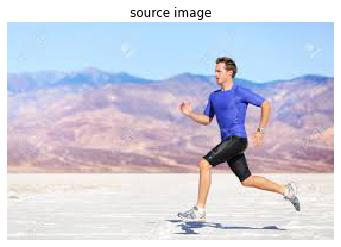

# captions: 25000, dimension: 1024
retrieval time elapsed: 00s
--------------------------------------------------
20 nearest neighbors of image:
A group of fur ducks walks along a wooden walkway.
A movie scene where actors are pretending to surf.
Headless statues show of clothing beneath a colored background.
unable to see this image in this particular hit
big statues of two beers dressed in clothes, outside
A group of lego figures standing on a and near a laptop.
The skiier easily and skillfully jumps the small mogul.
A person who is in a duck costume.
I am unable to see an image above.
I am unable to see an image above.
I am unable to see an image above.
I am unable to see an image above.
I am unable to see an image above.
A group of 20 small photos in a collage together, with each photo containing a carrot in it.
A nat naps with his head on a sneaker.
I am unable to see the image above.
A guy wear a short khaki pants and brown tee is on a skate board.
Two customers and three employe

In [8]:
%matplotlib inline
retrieve_i2c(dset, val_dset, "samples/sample1.jpg", imenc, transform, k=20)

--------------------------------------------------
source caption: 'a picture of a tasty-looking noodle soup.'
# images: 5000, dimension: 1024
retrieval time elapsed: 00s
--------------------------------------------------
10 nearest neighbors of 'a picture of a tasty-looking noodle soup.'


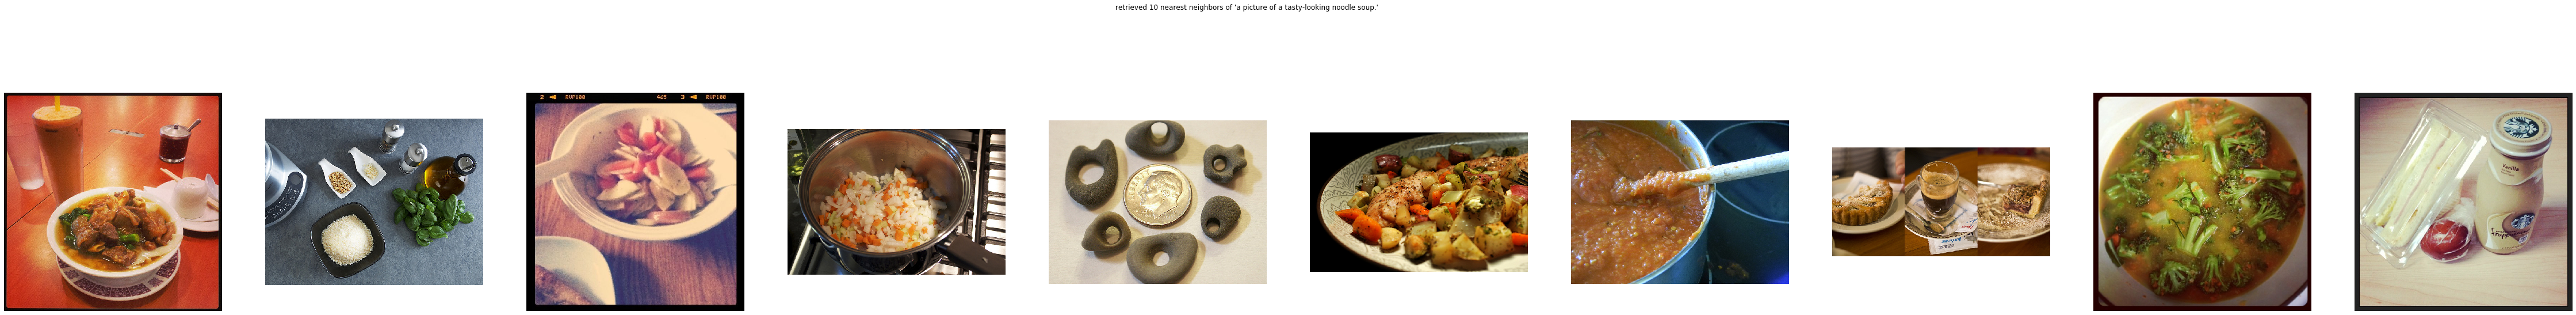

--------------------------------------------------


In [9]:
%matplotlib inline
caption = "a picture of a tasty-looking noodle soup."
retrieve_c2i(dset, val_dset, caption, capenc, vocab, k=10)